In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!ls

ODIR-5K  ODIR-5K.zip


In [ ]:
!unzip /content/gdrive/MyDrive/Kaggle/ODIR-5K_aug.zip

Streaming output truncated to the last 5000 lines.
  inflating: ODIR-5K/ODIR-5K/Training Images/2048_leftBFRR-H.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/2048_leftBFRRRB-H.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/2048_leftBFRB-H.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/2048_leftZMRR-H.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/2048_leftZMRRRB-H.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/2048_leftZMRB-H.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/2070_leftVF-H.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/2070_leftHF-H.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/2070_leftBF-H.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/2070_leftZM-H.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/2070_leftVFZM-H.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/2070_leftHFZM-H.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/2070_leftBFZM-H.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/2070_leftRB-H.jpg  
  inflating: ODIR

In [ ]:
!cp /content/ODIR-5K_aug.zip  /content/gdrive/MyDrive/ODIR-5K_aug

In [ ]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob
import random

BATCH_SIZE = 32
IMG_HEIGHT = 250
IMG_WIDTH = 250
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

In [ ]:
resampled1_ds = tf.data.Dataset.list_files("/content/gdrive/MyDrive/Kaggle/ODIR-5K/ODIR-5K/Training Images/*.jpg")
test_ds = tf.data.Dataset.list_files("/content/gdrive/MyDrive/Kaggle/ODIR-5K/ODIR-5K/Validation_Images/*.jpg")

In [ ]:
def get_label(name):
  parts = tf.strings.split(name, sep="-")
  label = tf.strings.split(parts[-1], sep=".")
  label = tf.strings.bytes_split(label[0])
  l = [0, 0, 0, 0, 0, 0, 0, 0]

  for e in label:
    if e != '&' and e != 'X':
      if e == 'N':
        l[0] = 1
      elif e == 'D':
        l[1] = 1
      elif e == 'G':
        l[2] = 1
      elif e == 'C':
        l[3] = 1
      elif e == 'A':
        l[4] = 1
      elif e == 'H':
        l[5] = 1
      elif e == 'M':
        l[6] = 1
      elif e == 'O':
        l[7] = 1

  return l

def get_name(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  #img = tf.image.adjust_contrast(img, 2)
  img = tf.image.convert_image_dtype(img, tf.float32)
  #img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return img

def process_path(file_path):
  name = get_name(file_path)
  label = get_label(name)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
resampled_named_ds = resampled1_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_named_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
type(resampled_named_ds)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


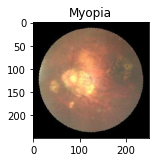

In [ ]:
i=1
plt.figure(figsize=(12,7))
for image, label in resampled_named_ds.take(10):
    if CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]]== 'N':
        labelx = "Normal"
    elif CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]]== 'C':
        labelx = "Cataract"
    elif CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]]== 'D':
        labelx = "Diabete"
    elif CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]]== 'G':
        labelx = "Glaucoma"
    elif CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]]== 'A':
        labelx = "Age"
    elif CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]]== 'M':
        labelx = "Myopia"
    elif CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]]== 'H':
        labelx = "Hypertension"
    elif CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]]== 'O':
        labelx = "Other"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.title(labelx)
    if i == 10:
      break
plt.show()

In [ ]:
def randomly_augment(image,label):
  image = tf.image.random_flip_left_right(image)
  #image = tf.image.central_crop(image, central_fraction=0.9)
  #image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return image, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  #ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=False)
  #ds = ds.map(randomly_augment, num_parallel_calls=AUTOTUNE)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE, drop_remainder=True)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  ds = ds.cache()
  ds = ds.batch(32, drop_remainder=True) #all elemetnts for training should be batched in one!
  ds = ds.repeat()

  return ds

In [ ]:
final_train_ds = prepare_for_training(resampled_named_ds,cache=True,shuffle_buffer_size=3000)
final_test_ds = prepare_for_testing(test_named_ds,cache=True,shuffle_buffer_size=100)

[0 0 0 0 0 0 1 0]


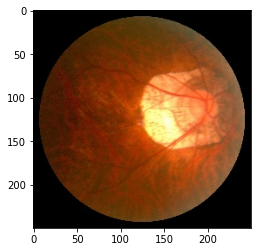

In [ ]:
for example in final_train_ds.take(1):
  image, label = example
  break
im, lab = image[13], label[13]
plt.imshow(im.numpy())
print(lab.numpy())

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
from keras.layers import Dense, Dropout, Activation
vgg16_weight_path = '/content/gdrive/MyDrive/Kaggle/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
image_size= 250
vgg = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=(224,224,3)
)

In [ ]:
for layer in vgg.layers:
    layer.trainable = False
model = Sequential()
model.add(vgg)
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='softmax'))
model.add((Dropout(rate=0.2)))
model.add(Dense(128, activation='relu'))
model.add((Dropout(0.1)))
model.add(Flatten())
model.add(Dense(8,activation="softmax"))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 7, 7, 256)         131328    
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 256)         0         
_________________________________________________________________
dense_5 (Dense)              (None, 7, 7, 128)         32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
dense_6 (Dense)              (None, 7, 7, 128)         16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)        

In [ ]:
#history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),verbose=1,callbacks=[checkpoint,earlystop])
history = model.fit(final_train_ds,
                    #batch_size=32,
                    epochs=12,
                    steps_per_epoch = 200, #train_elements/batch_size
                    validation_data=final_test_ds,
                    validation_steps = 33,
                    use_multiprocessing=True,
                    #class_weight=class_weight
                    )

Epoch 1/12
200/200 [==============================] - 5001s 24s/step - loss: 2.0629 - accuracy: 0.1751 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.4542 - val_accuracy: 0.0473 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/12
200/200 [==============================] - 4735s 24s/step - loss: 1.8699 - accuracy: 0.2814 - precision: 0.6989 - recall: 0.0113 - val_loss: 2.3241 - val_accuracy: 0.1155 - val_precision: 0.4861 - val_recall: 0.0616
Epoch 3/12
200/200 [==============================] - 4726s 24s/step - loss: 1.5130 - accuracy: 0.4611 - precision: 0.8507 - recall: 0.2110 - val_loss: 2.1799 - val_accuracy: 0.1714 - val_precision: 0.5364 - val_recall: 0.1042
Epoch 4/12
200/200 [==============================] - 4749s 24s/step - loss: 1.3104 - accuracy: 0.5503 - precision: 0.8506 - recall: 0.3038 - val_loss: 2.1439 - val_accuracy: 0.1828 - val_precision: 0.4603 - val_recall: 0.1034
Epoch 5/12
200/200 [==============================] - 4795s 24s/step - loss: